# （1）Ipynb_importer needed for calling other .ipynb scripts

In [73]:
"""""""""
Written by Mengzhan Liufu and Sameera Shridhar at Yu Lab, the University of Chicago, November 2021
"""""""""
import Ipynb_importer

In [74]:
import TrodesReader
from collections import deque
import numpy as np
import math
from scipy import signal
import matplotlib.pyplot as plt

# （2）Functions for testing

In [75]:
def bandpass_filter(filter_name, flattened_array, sampling_freq, order, lowcut, highcut):
    """
    Return a dictionary of filtered lfp data

    :param filter_name: name of the filter you want to use
    :type filter_name: string
    :param flattened_array: array of the raw lfp data
    :type flattened_array: np array
    :param sampling_freq: frequency lfp data was sampled at
    :type sampling_freq: int
    :param order: order of filter
    :type order: int
    :param lowcut: lower border of frequencies allowed to pass
    :type lowcut: int
    :param highcut: upper border of frequencies allowed to pass
    :type highcut: int

    :return: filtered lfp data
    :rtype: np array
    """
    if filter_name == 'elliptical':
        sos = signal.ellip(order, 0.01, 120, [lowcut, highcut], btype='bp', output='sos', fs=sampling_freq)
    if filter_name == 'butterworth':
        sos = signal.butter(order, [lowcut, highcut], 'bp', fs=sampling_freq, output='sos')
    if filter_name == 'cheby1':
        sos = signal.cheby1(order, 1, [lowcut, highcut], 'bp', fs=sampling_freq, output='sos')
    if filter_name == 'cheby2':
        sos = signal.cheby2(order, 15, [lowcut, highcut], 'bp', fs=sampling_freq, output='sos')

    y = signal.sosfiltfilt(sos, flattened_array)

    return y

def calculate_rms(buffer):
    """
    return the root mean-squared of a given array
    :param buffer: any array or list of number

    :return: the root mean-squared value of the array as a proxy for its power
    :rtype: float
    """
    square_summed = 0
    for k in buffer:
        square_summed += (k**2)

    return math.sqrt(square_summed/len(buffer))


def detection_with_rms(buffer, low_cut, high_cut, threshold):
    """
    :param buffer: the buffer of lfp data at current iteration
    :param low_cut: the lower bound of the frequency band of interest
    :param high_cut: the upper bound of the frequency band of interest
    :param threshold: the threshold of power for making decision/judgement

    :return: whether there is activity in freq range [low_cut, high_cut] or not
    :rtype: boolean
    """
    filtered_buffer = bandpass_filter('butterworth', buffer, lfp_sampling_rate, 1, low_cut, high_cut)
    current_rms = calculate_rms(filtered_buffer)
    if current_rms >= threshold:
        return True
    else:
        return False

# （3）Load Raw LFP Data

In [76]:
lfp_sampling_rate = 1250
lfp_sampling_period = (1/1250)*(10**9)
fNQ = 600

data_path = r'C:\Users\John LauFoo\Box\Jhan\ClosedLoopControl Project\DATA\20211117_testing_5min\20211117_testing_5min.LFP\20211117_testing_5min.LFP_nt28ch1.dat'
timestamp_path = r'C:\Users\John LauFoo\Box\Jhan\ClosedLoopControl Project\DATA\20211117_testing_5min\20211117_testing_5min.LFP\20211117_testing_5min.timestamps.dat'

In [77]:
data = TrodesReader.readTrodesExtractedDataFile(data_path)
timestamps = TrodesReader.readTrodesExtractedDataFile(timestamp_path)

lfp_data = []
for i in data['data']:
    lfp_data.append(i[0])

<string>:69: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.


# （4）Filter the whole recording for different frequency bands

In [128]:
#ripple_range_filtered_data = bandpass_filter('butterworth', lfp_data, lfp_sampling_rate, 1, 140, 225)
#sharp_wave_range_filtered_data = bandpass_filter('butterworth', lfp_data, lfp_sampling_rate, 1, 5, 15)
#gamma_range_filtered_data = bandpass_filter('butterworth', lfp_data, lfp_sampling_rate, 1, 20, 40)
theta_range_filtered_data = bandpass_filter('butterworth', lfp_data, lfp_sampling_rate, 1, 4, 8)

# （5）Offline testing workflow (all ranges, full length)

In [16]:
ripple_rms_history = []
sharp_wave_rms_history = []
gamma_rms_history = []
for i in range(2499, len(ripple_range_filtered_data)):
    ripple_buffer = ripple_range_filtered_data[i-2499:i]
    ripple_rms_history.append(calculate_rms(ripple_buffer))
    '''
    sharp_wave_buffer = sharp_wave_range_filtered_data[i-2499:i]
    sharp_wave_rms_history.append(calculate_rms(sharp_wave_buffer))
    gamma_range_buffer = gamma_range_filtered_data[i-2499:i]
    gamma_rms_history.append(calculate_rms(gamma_range_buffer))
    '''

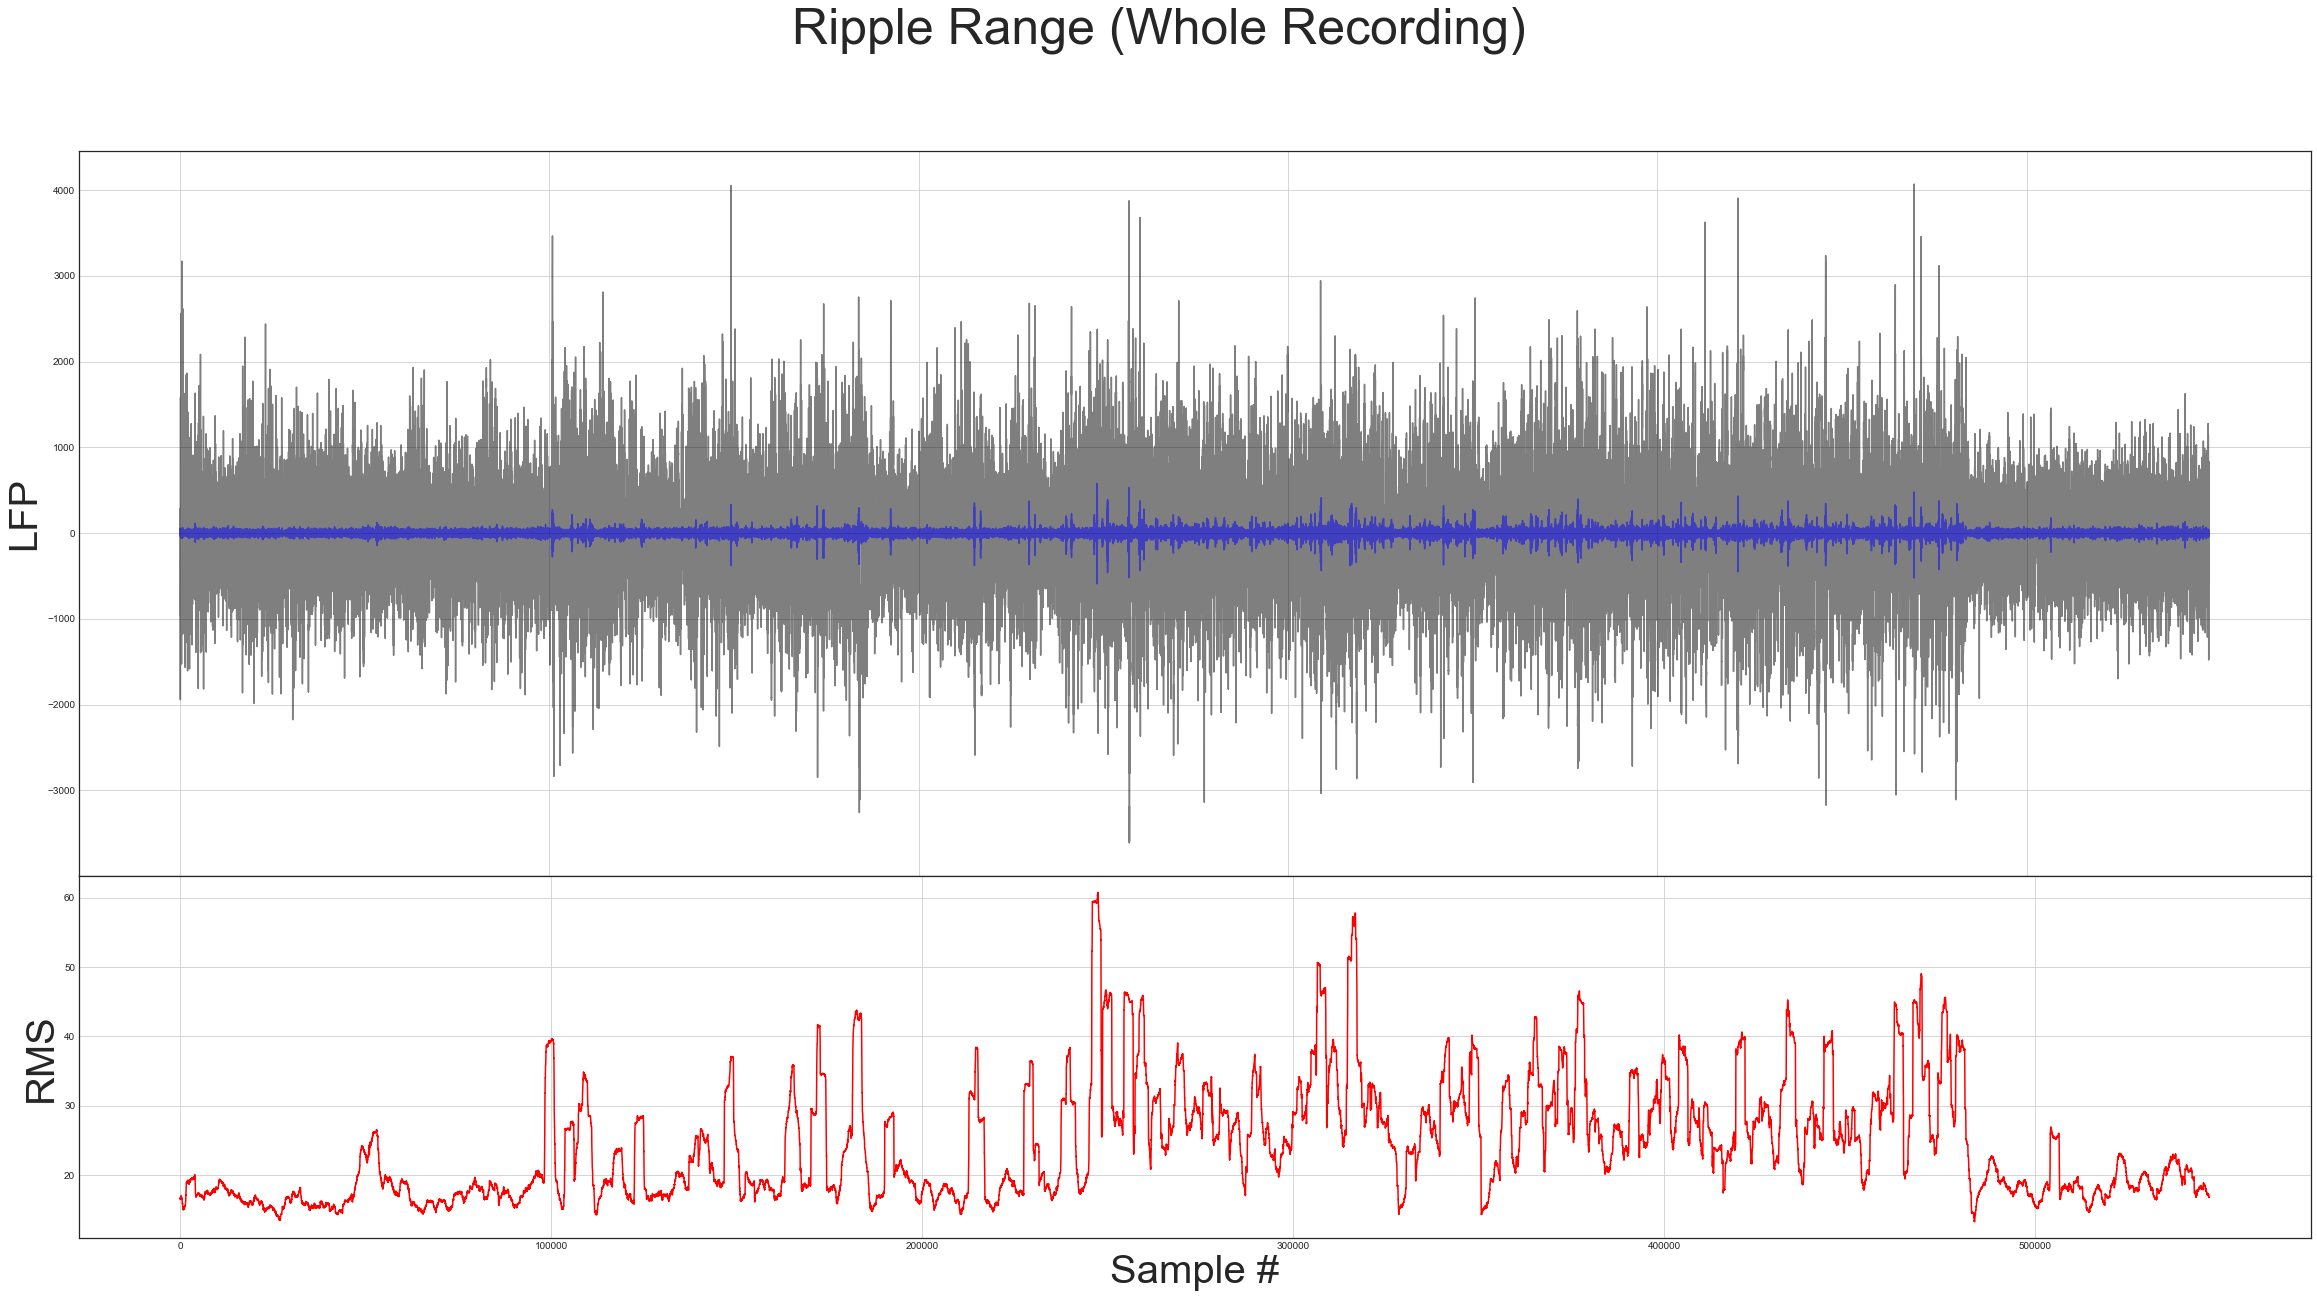

In [94]:
fig4 = plt.figure(figsize=(40,20))
grid = plt.GridSpec(6,1,wspace=0.5, hspace=0)
ax1 = plt.subplot(grid[0:4,0:1])
ax2 = plt.subplot(grid[4:6,0:1])

ax1.plot(lfp_data,color='k',alpha=0.5)
ax1.plot(ripple_range_filtered_data,color='b',alpha=0.5)
ax1.grid(True)
ax1.set_ylabel('LFP',fontsize=40)
ax2.plot(ripple_rms_history,color='r')
ax2.grid(True)
ax2.set_xlabel('Sample #',fontsize=40)
ax2.set_ylabel('RMS',fontsize=40)

plt.style.use('seaborn-white')
plt.suptitle('Ripple Range (Whole Recording)',fontsize=50)
plt.show()

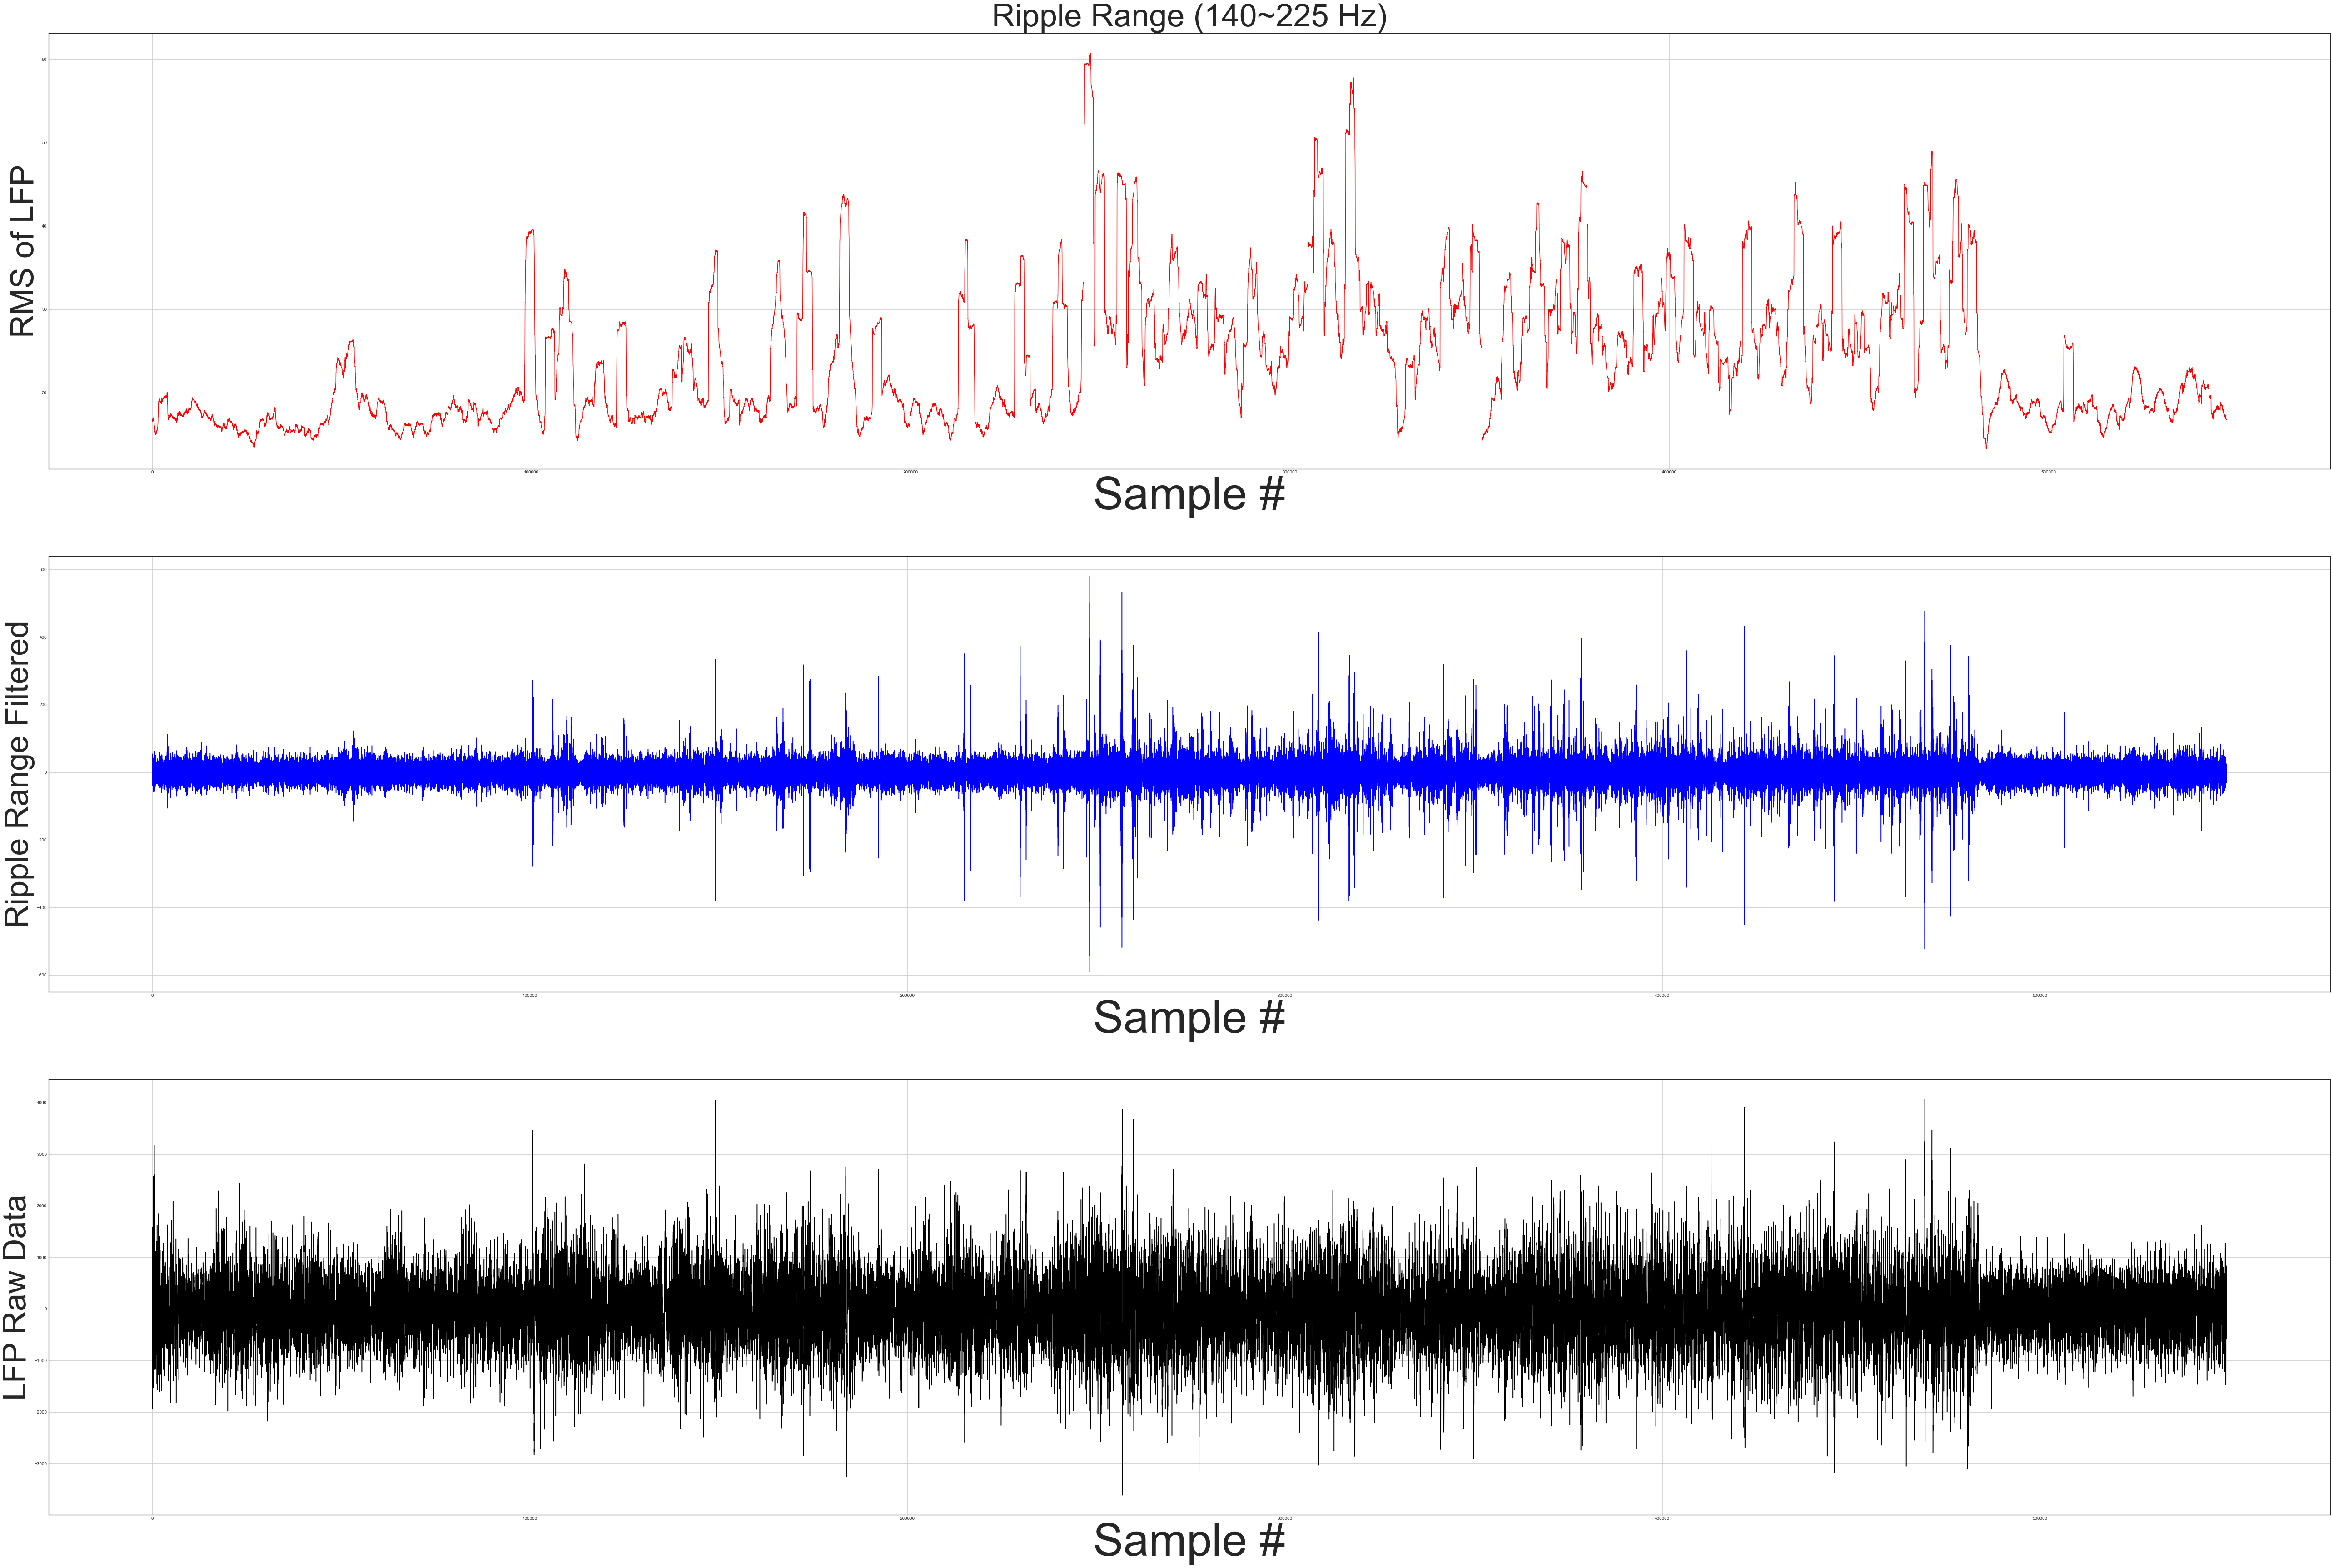

In [17]:
fig1 = plt.figure(figsize=(90,60))

ripple_plot = fig1.add_subplot(3,1,1)
raw_data_plot = fig1.add_subplot(3,1,3)
ripple_range_filtered_plot = fig1.add_subplot(3,1,2)

ripple_plot.plot(ripple_rms_history,'r')
ripple_plot.set_ylabel('RMS of LFP',fontsize=70)
ripple_plot.set_xlabel('Sample #',fontsize=100)
ripple_plot.grid(True)
ripple_plot.set_title('Ripple Range (140~225 Hz)',fontsize=70)

raw_data_plot.plot(lfp_data,'k')
raw_data_plot.set_ylabel('LFP Raw Data',fontsize=70)
raw_data_plot.set_xlabel('Sample #',fontsize=100)
raw_data_plot.grid(True)

ripple_range_filtered_plot.plot(ripple_range_filtered_data,'b')
ripple_range_filtered_plot.set_ylabel('Ripple Range Filtered',fontsize=70)
ripple_range_filtered_plot.set_xlabel('Sample #',fontsize=100)
ripple_range_filtered_plot.grid(True)

plt.style.use('seaborn-white')
plt.savefig(r'C:\Users\John LauFoo\Desktop\fig1.png')
plt.show()

In [13]:
ripple_avg_rms = np.mean(ripple_rms_history)
sharp_wave_avg_rms = np.mean(sharp_wave_rms_history)
gamma_avg_rms = np.mean(gamma_rms_history)

ripple_std_rms = np.std(ripple_rms_history)
sharp_wave_std_rms = np.std(sharp_wave_rms_history)
gamma_std_rms = np.std(gamma_rms_history)

ripple_rms_threshold = ripple_avg_rms + 2*ripple_std_rms
sharp_wave_rms_threshold = sharp_wave_avg_rms + 2*sharp_wave_std_rms
gamma_rms_threshold = gamma_avg_rms + 2*gamma_std_rms

In [23]:
# Run the detection_with_rms() function independently on raw data

ripple_decision_list = [False, False, False]
sw_decision_list = [False, False, False]
gamma_decision_list = [False, False, False]

ripple_stimulation_list = []
sw_stimulation_list = []
gamma_stimulation_list = []

for i in range(2499, len(ripple_range_filtered_data)):
    buffer = lfp_data[i-2499:i]
    ripple_decision = detection_with_rms(buffer,140,225,ripple_rms_threshold)
    sw_decision = detection_with_rms(buffer,5,15,sharp_wave_rms_threshold)
    gamma_decision = detection_with_rms(buffer,20,40,gamma_rms_threshold)
    
    ripple_decision_list.append(ripple_decision)
    sw_decision_list.append(sw_decision)
    gamma_decision_list.append(gamma_decision)
    
    ripple_stimulation = False
    sw_stimulation = False
    gamma_stimulation = False
    for m in range(len(ripple_decision_list)-2, len(ripple_decision_list)):
        ripple_stimulation = ripple_decision_list[m]
        ripple_stimulation_list.append(ripple_stimulation)
        sw_stimulation = sw_decision_list[m]
        sw_stimulation_list.append(sw_stimulation)
        gamma_stimulation = gamma_decision_list[m]
        gamma_stimulation_list.append(gamma_stimulation)

NameError: name 'ripple_rms_threshold' is not defined

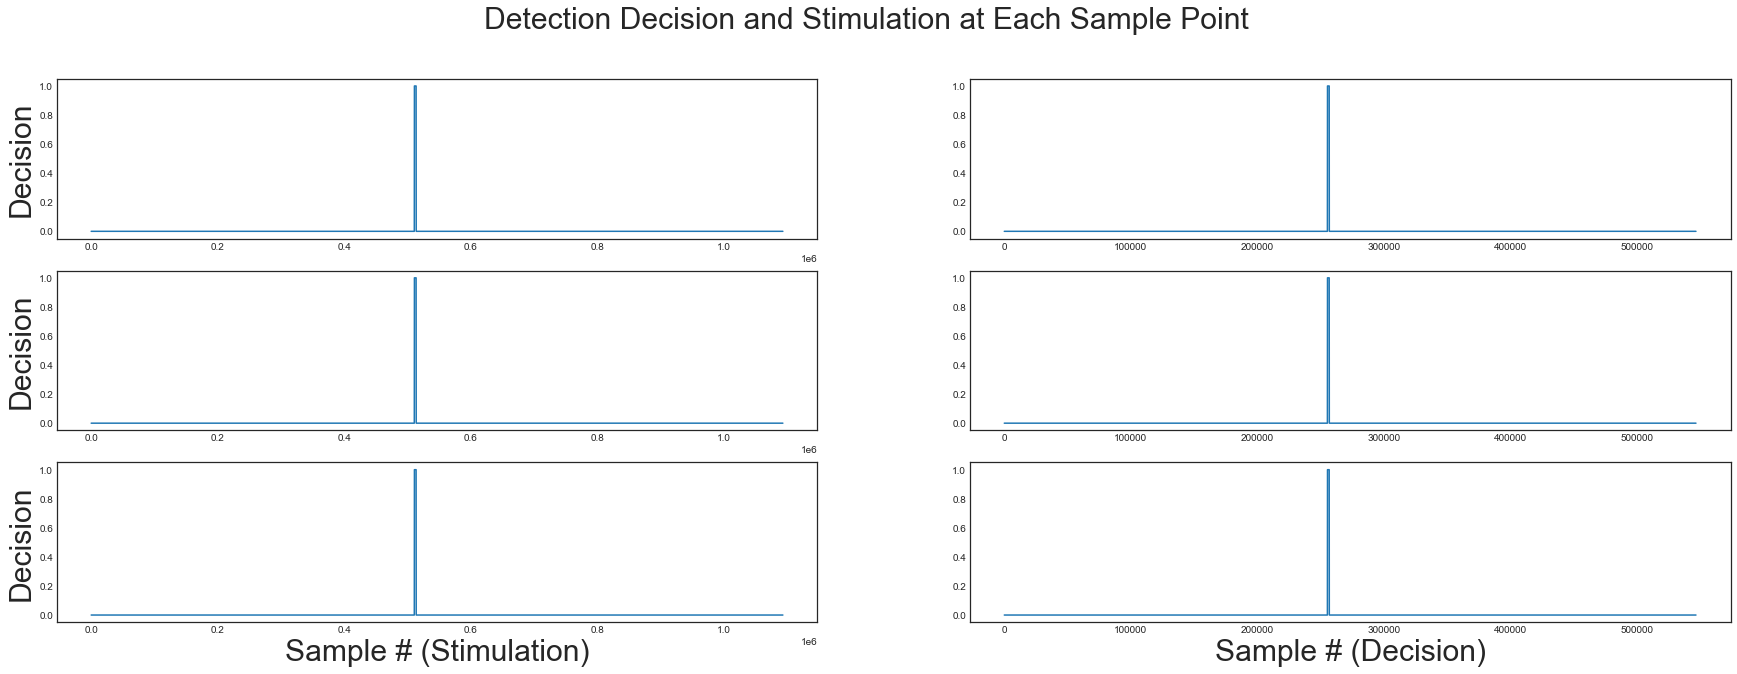

In [10]:
fig2 = plt.figure(figsize=(30,10))
plt.style.use('seaborn-white')
ripple_stimulation_plot = fig2.add_subplot(3,2,1)
ripple_decision_plot = fig2.add_subplot(3,2,2)
sw_stimulation_plot = fig2.add_subplot(3,2,3)
sw_decision_plot = fig2.add_subplot(3,2,4)
gamma_stimulation_plot = fig2.add_subplot(3,2,5)
gamma_decision_plot = fig2.add_subplot(3,2,6)

ripple_stimulation_plot.plot(ripple_stimulation_list)
ripple_stimulation_plot.set_ylabel('Decision',fontsize=30)
ripple_decision_plot.plot(ripple_decision_list)

sw_stimulation_plot.plot(sw_stimulation_list)
sw_stimulation_plot.set_ylabel('Decision',fontsize=30)
sw_decision_plot.plot(sw_decision_list)

gamma_stimulation_plot.plot(gamma_stimulation_list)
gamma_stimulation_plot.set_ylabel('Decision',fontsize=30)
gamma_stimulation_plot.set_xlabel('Sample # (Stimulation)',fontsize=30)
gamma_decision_plot.plot(gamma_decision_list)
gamma_decision_plot.set_xlabel('Sample # (Decision)',fontsize=30)

plt.suptitle('Detection Decision and Stimulation at Each Sample Point',fontsize=30)
plt.show()

# （6）Testing with 10s segments, with buffer lengths of 500 samples and 2500 samples

## a. Buffer length 2500 samples

In [10]:
ripple_rms_history_short_buffer2500 = []
#sharp_wave_rms_history_short = []
#gamma_rms_history_short = []

for i in range(2499,14999):
    ripple_buffer_2500 = ripple_range_filtered_data[i-2499:i]
    ripple_rms_history_short_buffer2500.append(calculate_rms(ripple_buffer_2500))

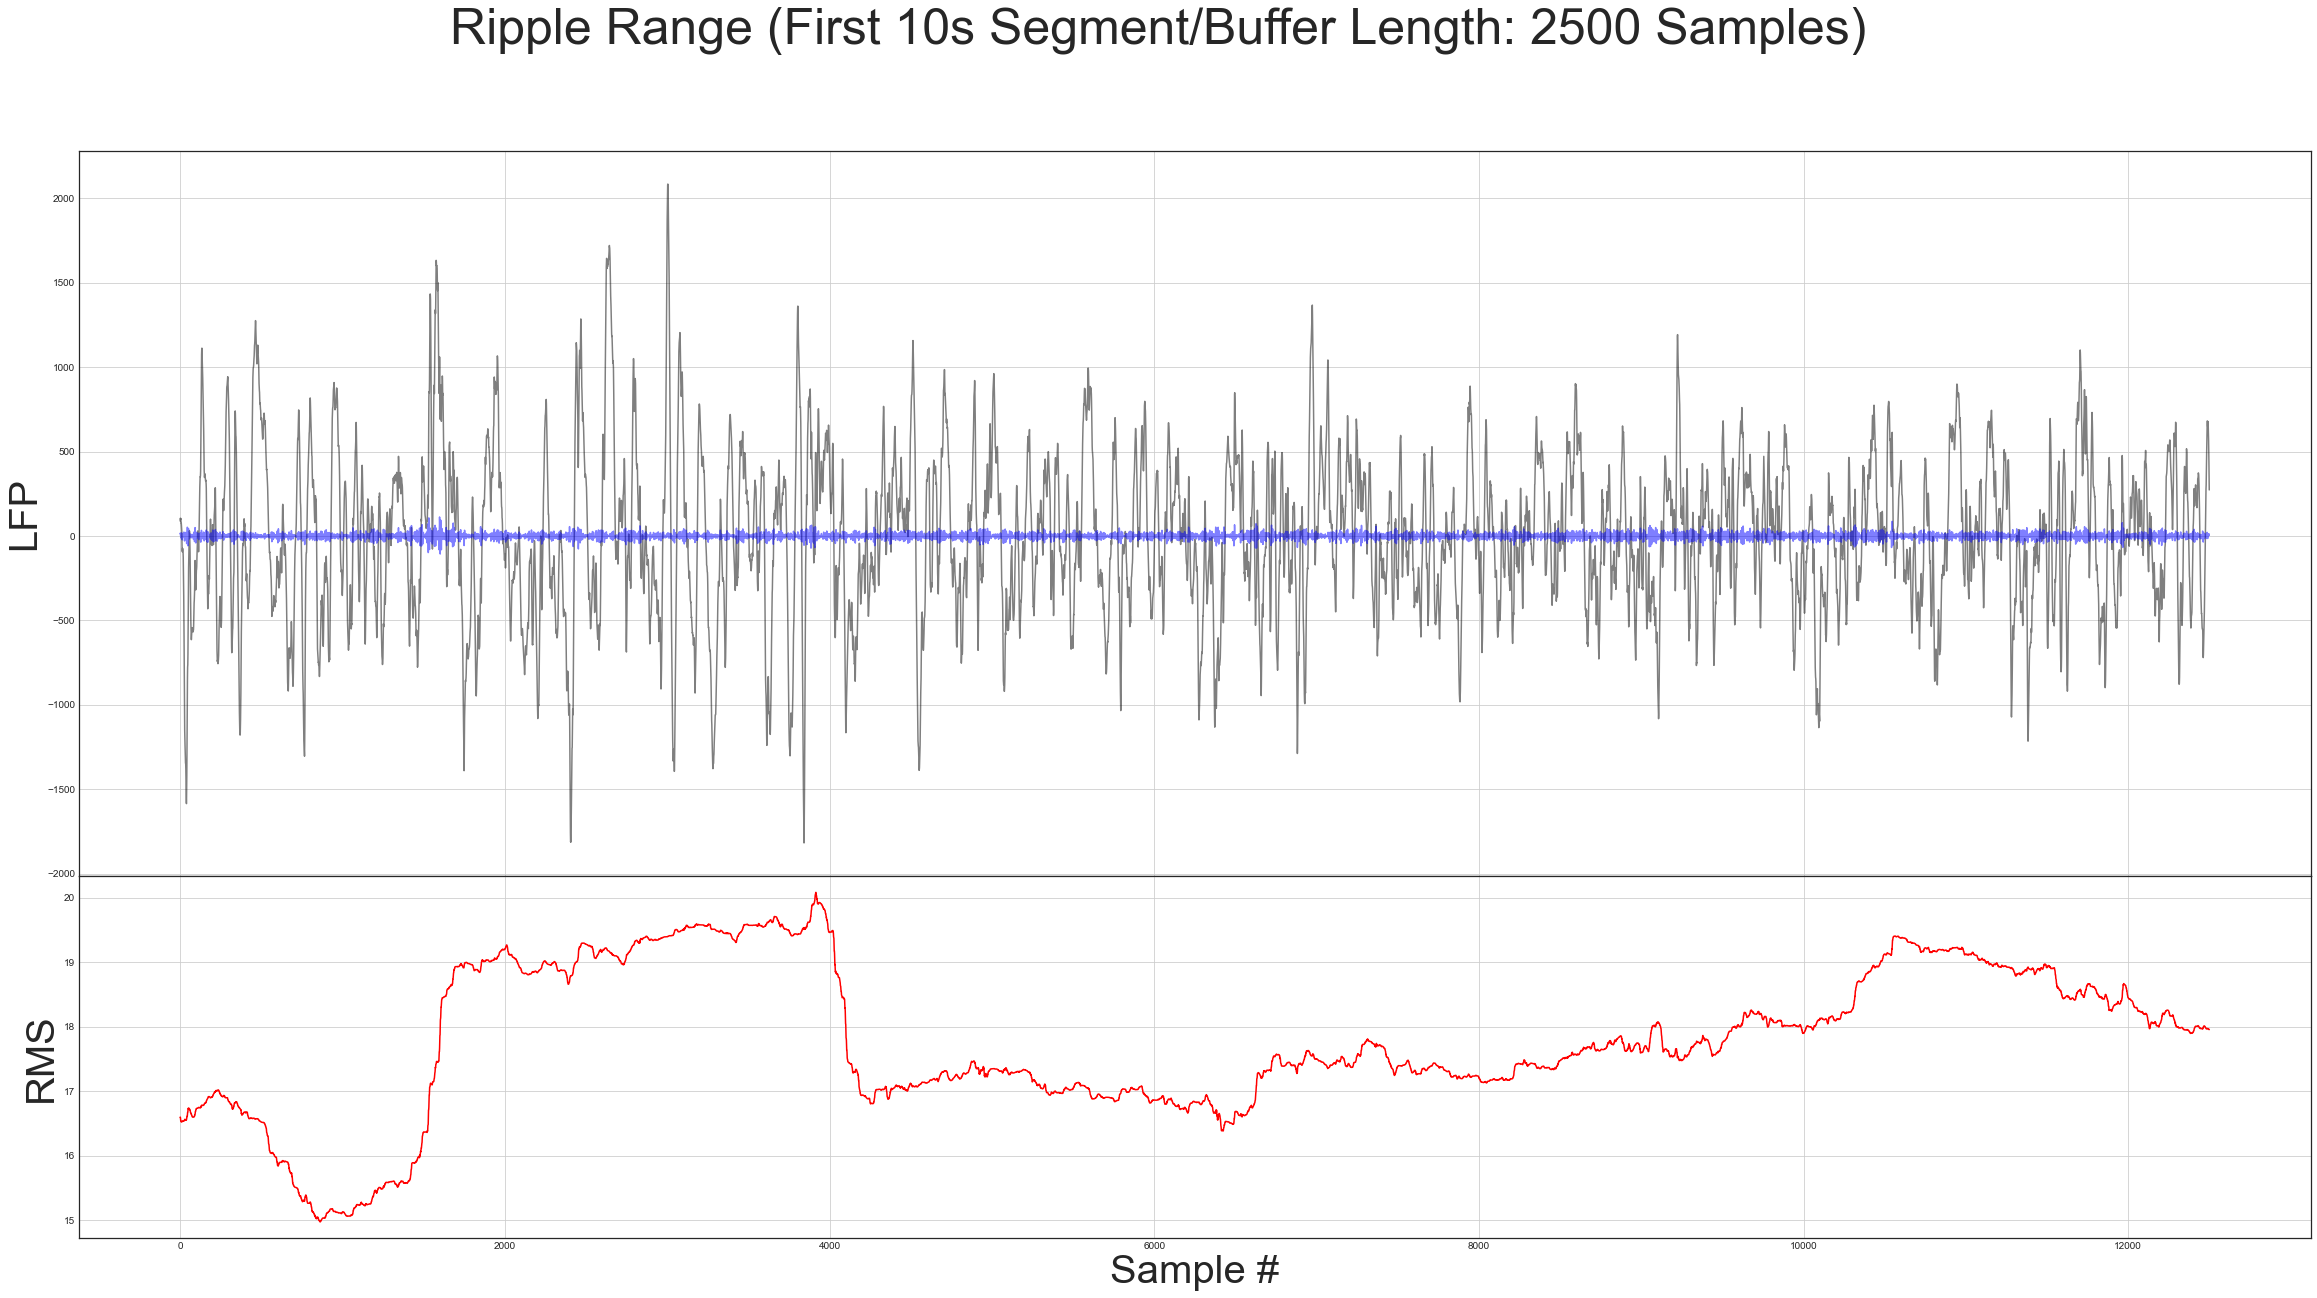

In [18]:
fig5 = plt.figure(figsize=(40,20))
grid = plt.GridSpec(6,1,wspace=0.5, hspace=0)
ax1 = plt.subplot(grid[0:4,0:1])
ax2 = plt.subplot(grid[4:6,0:1])

ax1.plot(lfp_data[2499:14999],color='k',alpha=0.5)
ax1.plot(ripple_range_filtered_data[2499:14999],color='b',alpha=0.5)
ax1.grid(True)
ax1.set_ylabel('LFP',fontsize=40)
ax2.plot(ripple_rms_history_short_buffer2500,color='r')
ax2.grid(True)
ax2.set_xlabel('Sample #',fontsize=40)
ax2.set_ylabel('RMS',fontsize=40)

plt.style.use('seaborn-white')
plt.suptitle('Ripple Range (First 10s Segment/Buffer Length: 2500 Samples)',fontsize=50)
plt.savefig(r'C:\Users\John LauFoo\Desktop\fig5.png')
plt.show()

## b. buffer length 500 samples

In [129]:
#ripple_rms_history_short_buffer500 = []
#sw_rms_history_short_buffer500 = []
theta_rms_history_short_buffer500 = []

for i in range(2499,14999):
    #ripple_buffer_short_500 = ripple_range_filtered_data[i-499:i]
    #ripple_rms_history_short_buffer500.append(calculate_rms(ripple_buffer_short_500))
    theta_buffer_short_500 = theta_range_filtered_data[i-499:i]
    theta_rms_history_short_buffer500.append(calculate_rms(theta_buffer_short_500))

In [197]:
#Calculate detection threshold
#ripple_avg_rms_short_500 = np.mean(ripple_rms_history_short_buffer500)
#ripple_std_rms_short_500 = np.std(ripple_rms_history_short_buffer500)
#ripple_rms_threshold_short_500 = ripple_avg_rms_short_500 + 4*ripple_std_rms_short_500

#print('Average: ' + str(ripple_avg_rms_short_500))
#print('Standard deviation: ' + str(ripple_std_rms_short_500))
#print('Threshold: ' + str(ripple_rms_threshold_short_500))

theta_avg_rms_short_500 = np.mean(theta_rms_history_short_buffer500)
theta_std_rms_short_500 = np.std(theta_rms_history_short_buffer500)
theta_rms_threshold_short_500 = theta_avg_rms_short_500 + 3*theta_std_rms_short_500

print('Average: ' + str(theta_avg_rms_short_500))
print('Standard deviation: ' + str(theta_std_rms_short_500))
print('Threshold: ' + str(theta_rms_threshold_short_500))

Average: 182.93092329583018
Standard deviation: 63.16530039795797
Threshold: 372.42682448970413


In [198]:
# Run the detection_with_rms() function independently on raw data
#ripple_decision_list_short_500 = [False, False]
theta_decision_list_short_500 = [False, False]

#ripple_stimulation_list_short_500 = []
theta_stimulation_list_short_500 = []

for i in range(2499,14999):
    buffer = lfp_data[i-499:i]
    #ripple_decision_short_500 = detection_with_rms(buffer,140,225,ripple_rms_threshold_short_500)
    theta_decision_short_500 = detection_with_rms(buffer,4,8,theta_rms_threshold_short_500)
    #ripple_decision_list_short_500.append(ripple_decision_short_500)
    theta_decision_list_short_500.append(theta_decision_short_500)
    
    #ripple_stimulation_short_500 = False
    theta_stimulation_short_500 = True
    for m in range(len(theta_decision_list_short_500)-3, len(theta_decision_list_short_500)):
        if theta_decision_list_short_500[m] == False:
            theta_stimulation_short_500 = False
    
    theta_stimulation_list_short_500.append(theta_stimulation_short_500)

In [199]:
theta_decision_list_short_500.pop(0)
theta_decision_list_short_500.pop(0)

False

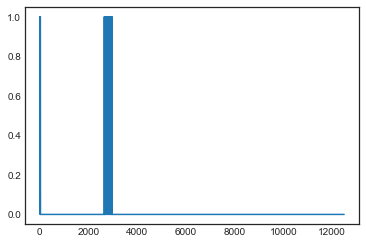

12500


In [202]:
#plt.plot(ripple_decision_list_short_500)
plt.plot(theta_decision_list_short_500)
plt.show()
print(len(theta_decision_list_short_500))

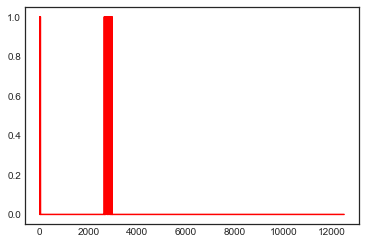

[False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, False, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, F

In [201]:
plt.plot(theta_stimulation_list_short_500,color='r')
plt.show()
print(theta_stimulation_list_short_500)

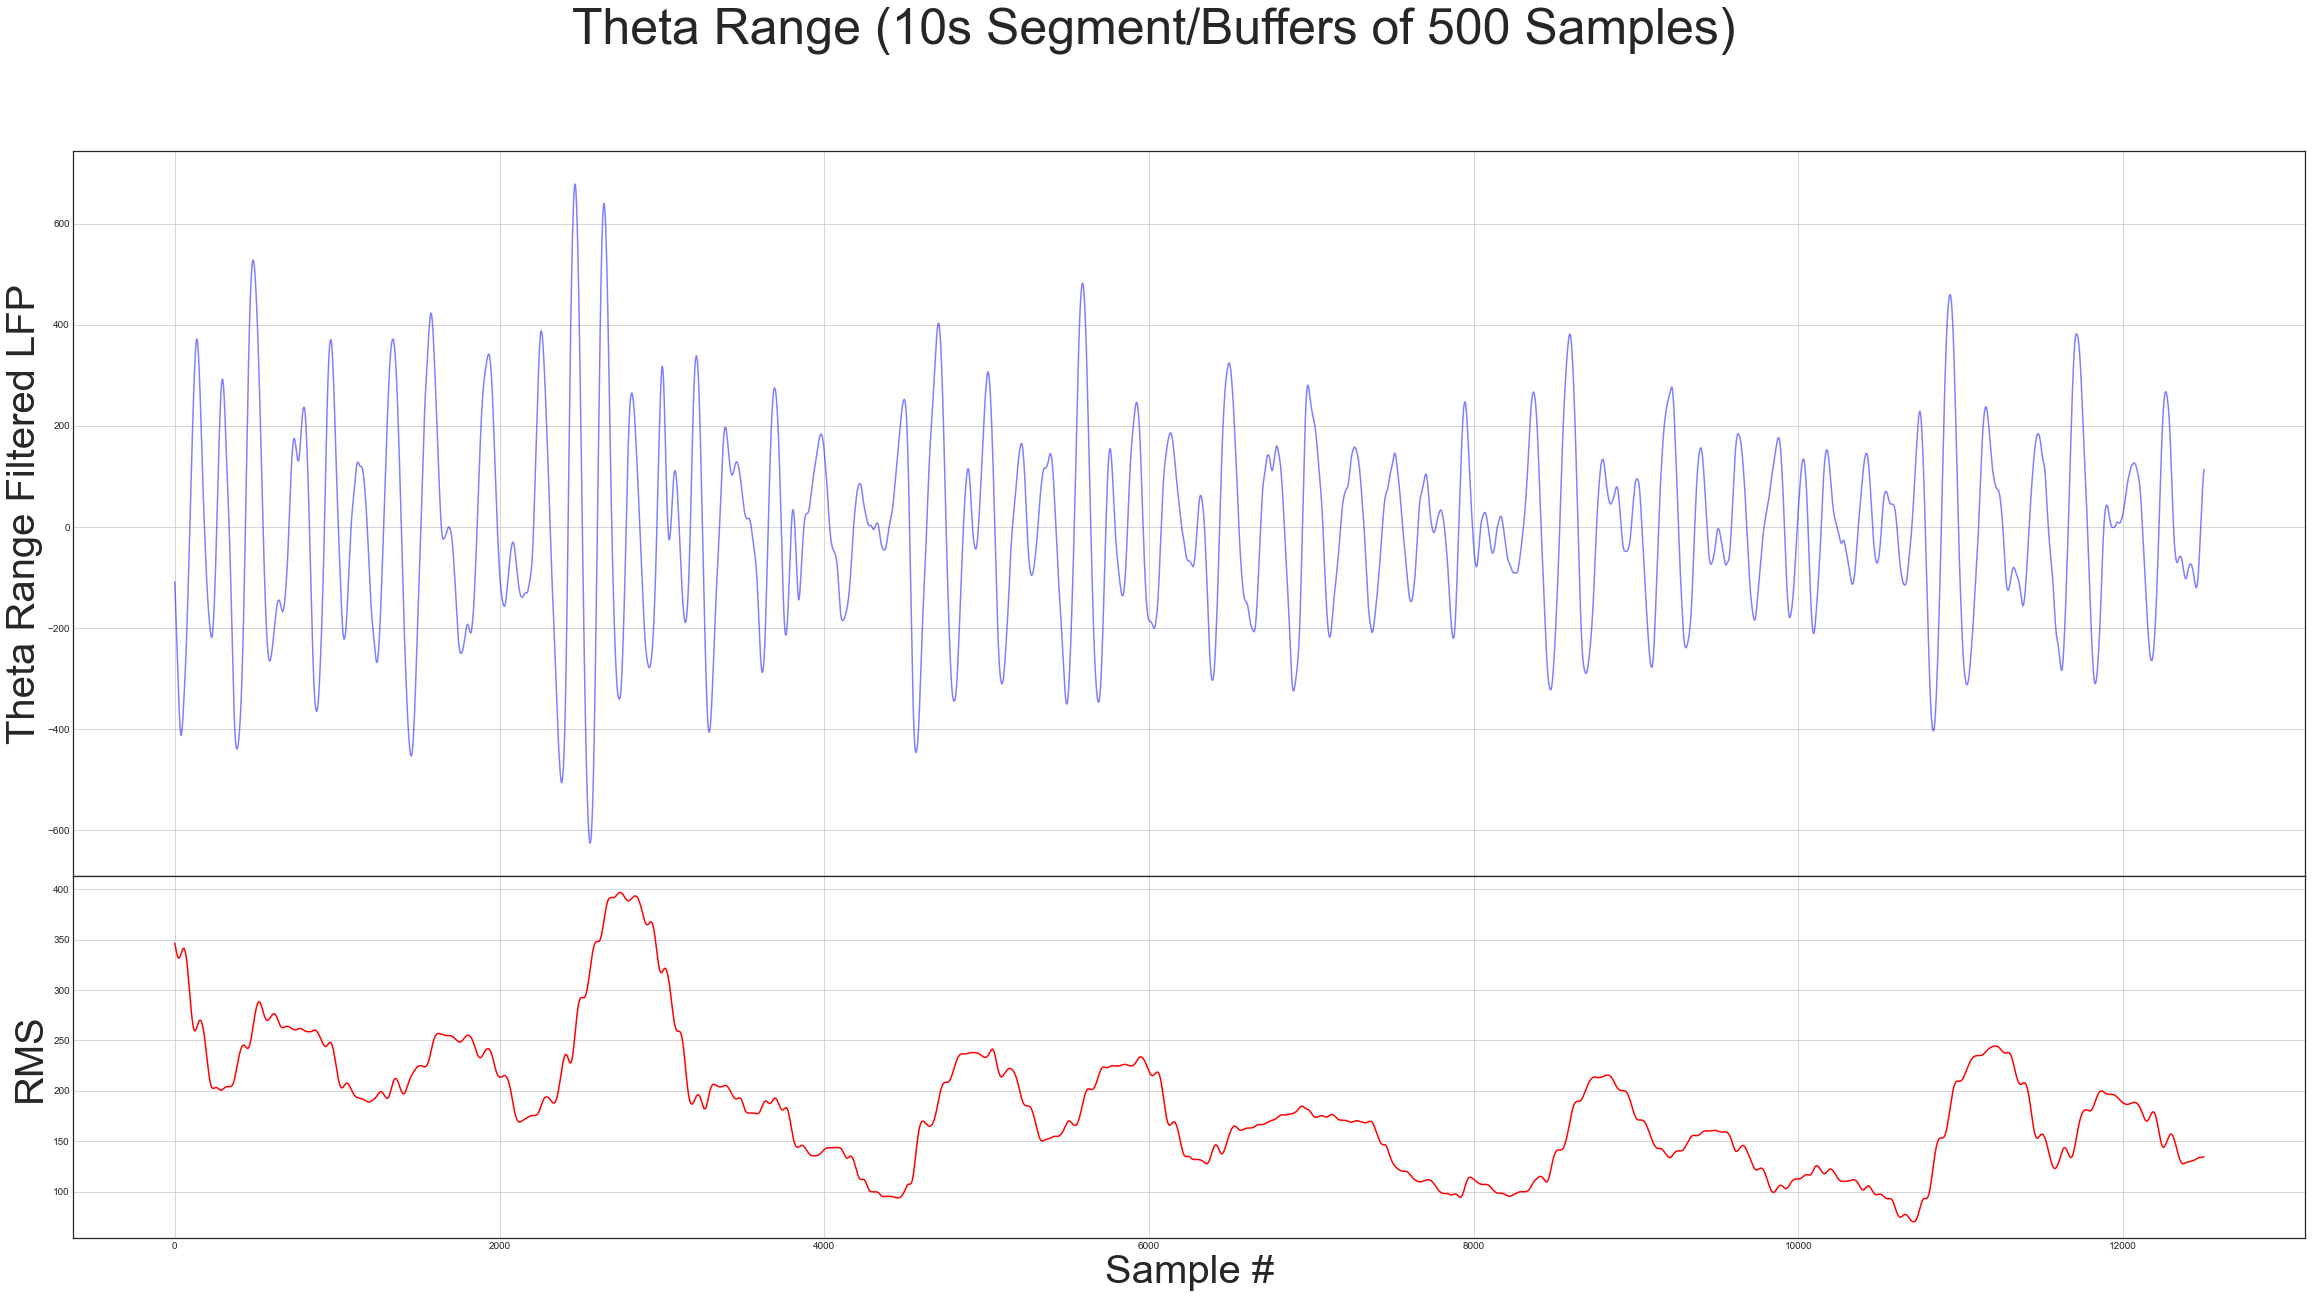

In [131]:
fig6 = plt.figure(figsize=(40,20))
grid = plt.GridSpec(6,1,wspace=0.5, hspace=0)
ax1 = plt.subplot(grid[0:4,0:1])
ax2 = plt.subplot(grid[4:6,0:1])

#ax1.plot(ripple_range_filtered_data[2499:14999],color='b',alpha=0.5)
#ax1.plot(sharp_wave_range_filtered_data[2499:14999],color='b',alpha=0.5)
ax1.plot(theta_range_filtered_data[2499:14999],color='b',alpha=0.5)
ax1.grid(True)
#ax1.set_ylabel('Ripple-range Filtered LFP',fontsize=40)
#ax1.set_ylabel('Sharp-wave Range Filtered LFP',fontsize=40)
ax1.set_ylabel('Theta Range Filtered LFP',fontsize=40)
#ax2.plot(ripple_rms_history_short_buffer500,color='r')
#ax2.plot(sw_rms_history_short_buffer500,color='r')
ax2.plot(theta_rms_history_short_buffer500,color='r')
ax2.grid(True)
ax2.set_xlabel('Sample #',fontsize=40)
ax2.set_ylabel('RMS',fontsize=40)

plt.style.use('seaborn-white')
#plt.suptitle('Ripple Range (10s Segment/Buffers of 500 Samples)',fontsize=50)
#plt.savefig(r'C:\Users\John LauFoo\Desktop\ripple_10s_500_rms+filtered.png')
#plt.suptitle('Sharp Wave Range (10s Segment/Buffers of 500 Samples)',fontsize=50)
#plt.savefig(r'C:\Users\John LauFoo\Desktop\sharp_wave_10s_500_rms+filtered.png')
plt.suptitle('Theta Range (10s Segment/Buffers of 500 Samples)',fontsize=50)
plt.savefig(r'C:\Users\John LauFoo\Desktop\theta_10s_500_rms+filtered.png')
plt.show()

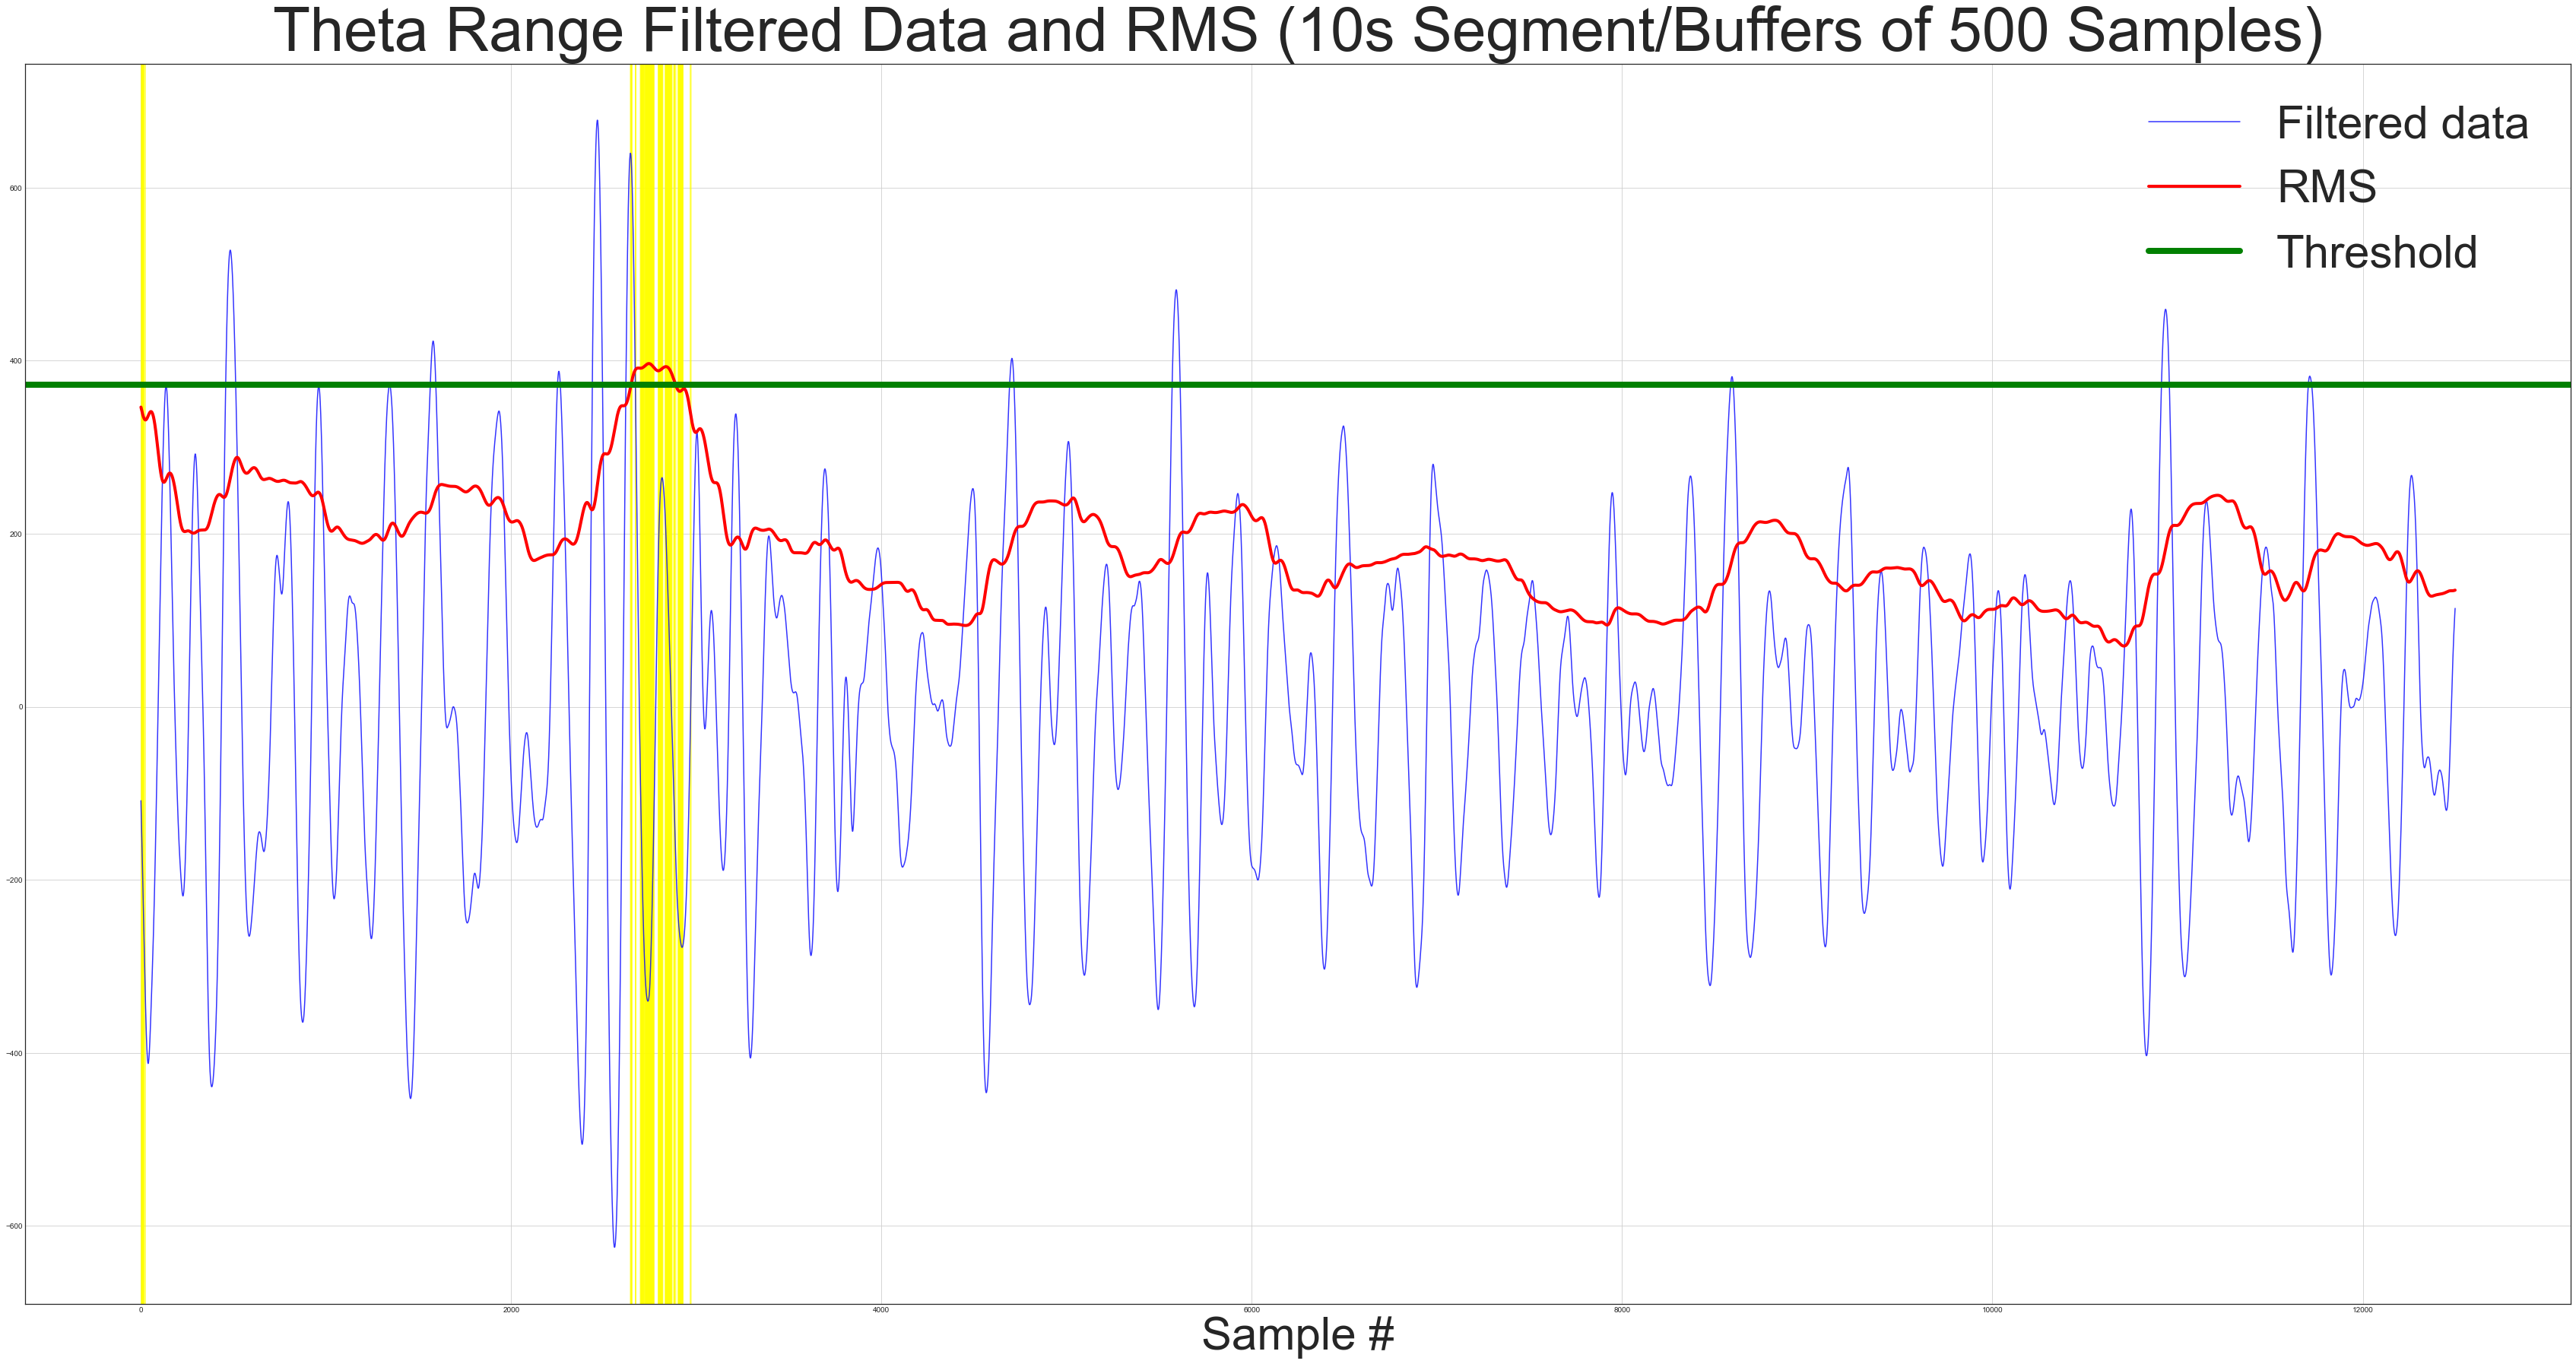

In [204]:
plt.figure(figsize=(60,30))

for s in range(0,len(theta_stimulation_list_short_500)):
    if theta_stimulation_list_short_500[s]:
        plt.axvline(x=s, color='yellow',alpha=0.5)

#plt.plot(ripple_range_filtered_data[2499:14999],color='b',alpha=0.5,label='Filtered data')
#plt.plot(sharp_wave_range_filtered_data[2499:14999],color='b',alpha=0.8,label='Filtered data')
plt.plot(theta_range_filtered_data[2499:14999],color='b',alpha=0.8,label='Filtered data')
#plt.plot(ripple_rms_history_short_buffer500,linewidth = '4', color='r',alpha=1,label='RMS')
#plt.plot(sw_rms_history_short_buffer500,linewidth = '4', color='r',alpha=1,label='RMS')
plt.plot(theta_rms_history_short_buffer500,linewidth = '4', color='r',alpha=1,label='RMS')
plt.axhline(y=theta_rms_threshold_short_500, color='green',linewidth = '8',label='Threshold')

plt.grid(True)
plt.xlabel('Sample #',fontsize=60)
#plt.title('Ripple-Range Filtered Data and RMS (10s Segment/Buffers of 500 Samples)',fontsize=80)
#plt.title('Sharp-wave Range Filtered Data and RMS (10s Segment/Buffers of 500 Samples)',fontsize=80)
plt.title('Theta Range Filtered Data and RMS (10s Segment/Buffers of 500 Samples)',fontsize=80)
plt.legend(fontsize=60)
#plt.savefig(r'C:\Users\John LauFoo\Desktop\sharp_wave_10s_500_rms+filtered(sup).png')
plt.savefig(r'C:\Users\John LauFoo\Desktop\theta_10s_500_rms+filtered(sup).png')
plt.show()

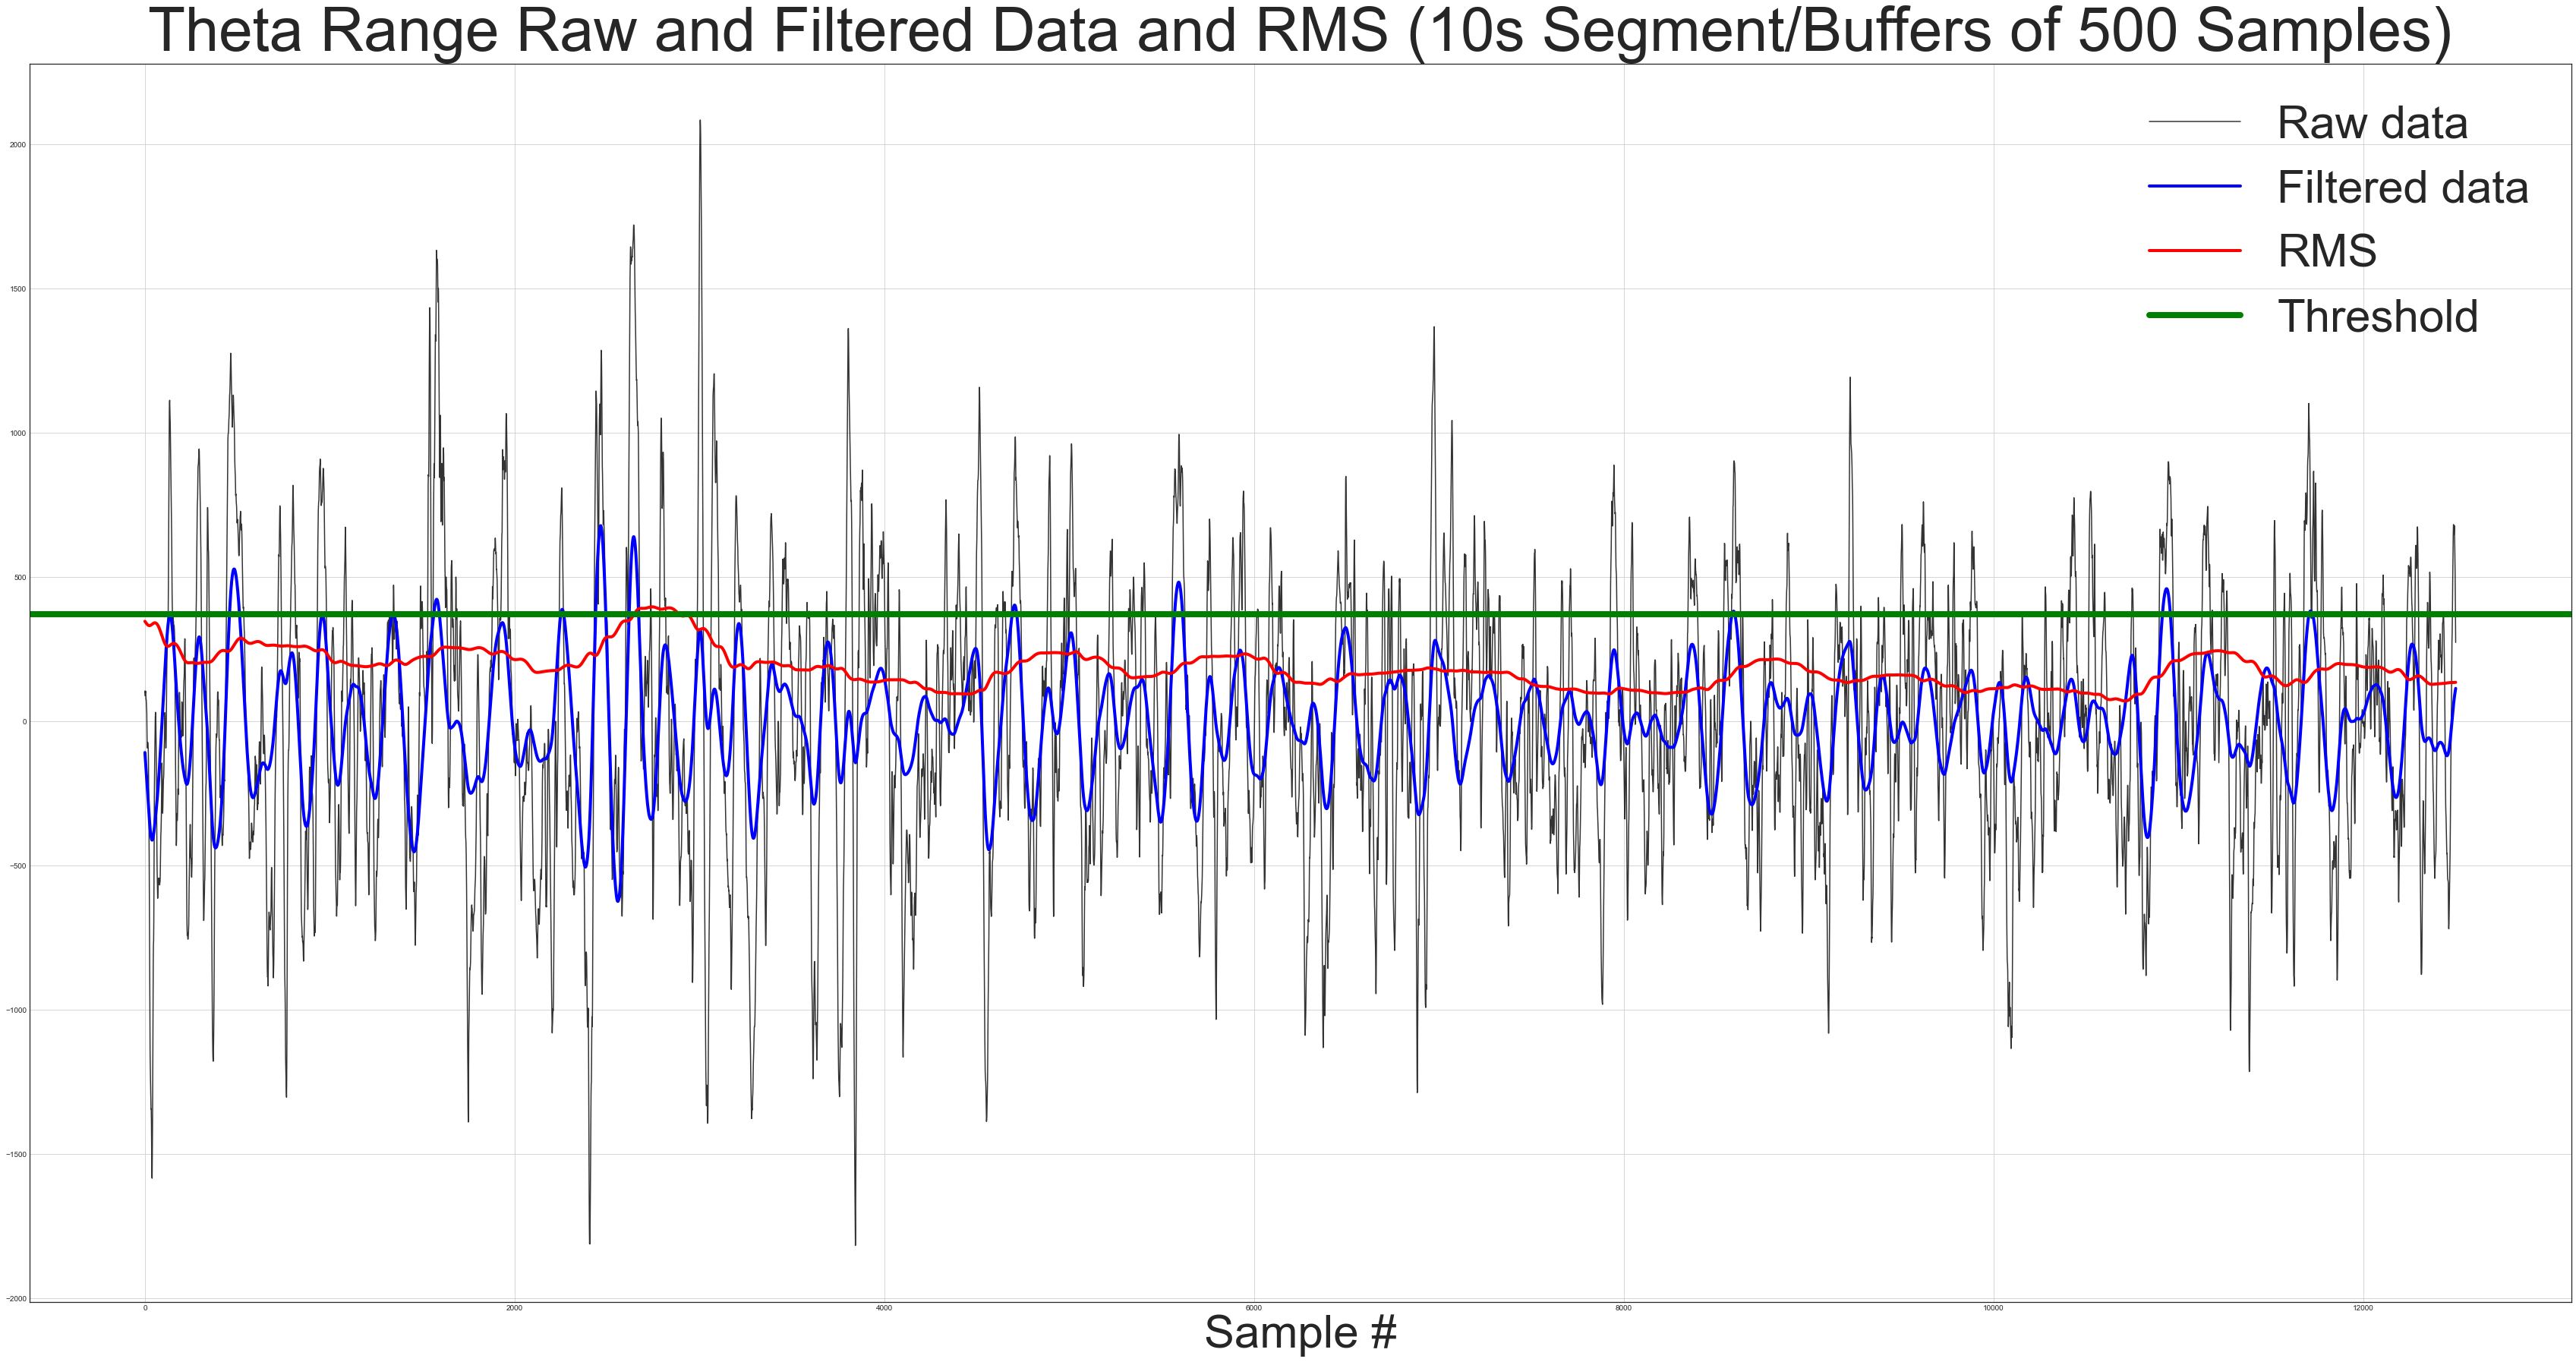

In [189]:
plt.figure(figsize=(60,30))
plt.style.use('seaborn-white')
plt.plot(lfp_data[2499:14999],color='k',alpha=0.8,label='Raw data')
#plt.plot(ripple_range_filtered_data[2499:14999],color='b',alpha=0.5,label='Filtered data')
#plt.plot(sharp_wave_range_filtered_data[2499:14999],linewidth = '4',color='b',alpha=1,label='Filtered data')
plt.plot(theta_range_filtered_data[2499:14999],color='b',linewidth = '4', alpha=1,label='Filtered data')
#plt.plot(ripple_rms_history_short_buffer500,linewidth = '4', color='r',alpha=1,label='RMS')
#plt.plot(sw_rms_history_short_buffer500,linewidth = '6', color='r',alpha=1,label='RMS')
plt.plot(theta_rms_history_short_buffer500,linewidth = '4', color='r',alpha=1,label='RMS')
plt.axhline(y=theta_rms_threshold_short_500, color='green',linewidth = '8',label='Threshold')
plt.grid(True)
#plt.title('Ripple-Range Raw and Filtered Data and RMS (10s Segment/Buffers of 500 Samples)',fontsize=80)
#plt.title('Sharp-wave Range Raw and Filtered Data and RMS (10s Segment/Buffers of 500 Samples)',fontsize=80)
plt.title('Theta Range Raw and Filtered Data and RMS (10s Segment/Buffers of 500 Samples)',fontsize=80)
plt.legend(fontsize=60)
plt.xlabel('Sample #',fontsize=60)
#plt.savefig(r'C:\Users\John LauFoo\Desktop\sw_10s_500_rms+filtered+raw(sup).png')
#plt.savefig(r'C:\Users\John LauFoo\Desktop\theta_10s_500_rms+filtered+raw(sup).png')
plt.show()